# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
#import visuals as vs
import visuals as vs
# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]  
# TODO: Number of records where individual's income is more than $50,000
rows_greater_50K = data[data.income==">50K"]
n_greater_50k = rows_greater_50K.income.count()

# TODO: Number of records where individual's income is at most $50,000
rows_at_most_50K = data[data.income=="<=50K"]
n_at_most_50k = rows_at_most_50K.income.count()
#Alternative way is to use shape
#n_at_most_50k = rows_at_most_50K.shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100*float(n_greater_50k)/float(n_records)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)


Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

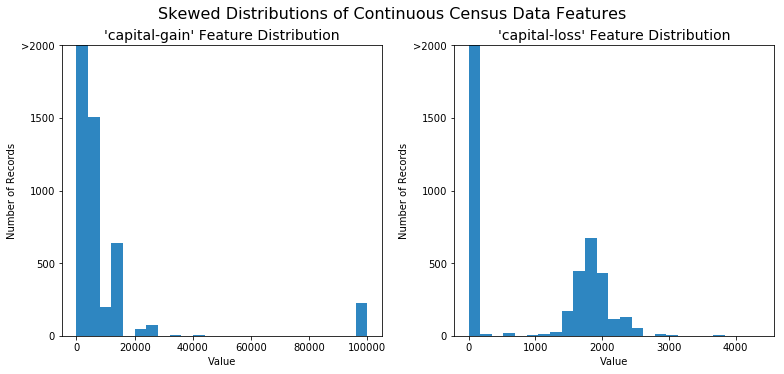

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

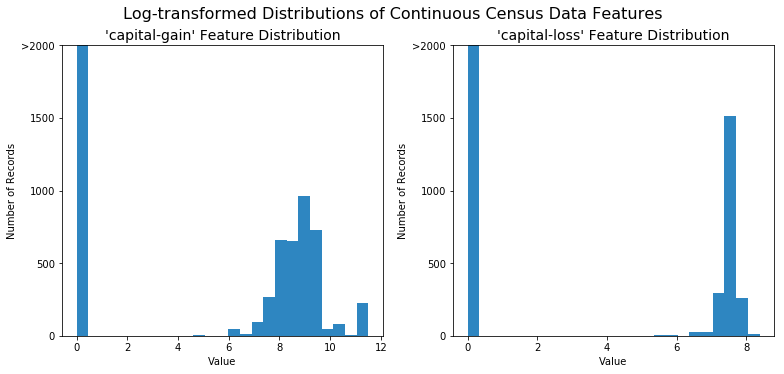

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])
# Show example of records with scaling applied
display(features_raw.head(n=5))
display(features_raw.tail(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
45217,0.219178,Private,Bachelors,0.8,Never-married,Prof-specialty,Own-child,White,Male,0.000000,0.0,0.397959,United-States
45218,0.301370,Private,Bachelors,0.8,Divorced,Prof-specialty,Not-in-family,White,Female,0.000000,0.0,0.357143,United-States
45219,0.287671,Private,Bachelors,0.8,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.000000,0.0,0.500000,United-States
45220,0.369863,Private,Bachelors,0.8,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,0.054551,0.0,0.397959,United-States
45221,0.246575,Self-emp-inc,Bachelors,0.8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.602041,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
##income = income_raw.apply(lambda y: 0 if y == '<=50K' else 1) # use a lambda function to assign appropriate binary (0, 1) coding
income = income_raw.apply(lambda y1: 0 if y1 =='<=50K' else (1 if y1=='>50K' else 99))# Value=99 applies to any other income values
# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded
print "Display first 12 one-hot-encoded features:"
display(encoded[:12])
print "Display first 12 incomes in (row, income) view --- after binary(0,1) encoding:"
display(income[:12])

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

['age',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_ Without-pay']

Display first 12 incomes in (row, income) view --- after binary(0,1) encoding:


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     1
8     1
9     1
10    1
11    1
Name: income, dtype: int64

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# TODO: Calculate accuracy
# If our naive model predicts all individuals make more than 50K, 
# then the "greater_percent" result calculated earlier in the Data Exploration Section reflects the accuracy fraction*100

accuracy = greater_percent/100.0

# Here, precision = accuracy
precision = accuracy
# And recall is 100%
recall = 1.0

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
fscore = (1+beta**2)*(precision*recall)/((precision*beta**2)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*


**Answer: ** 

Model set A (Logistic Regression, GaussianNB, and AdaBoost)

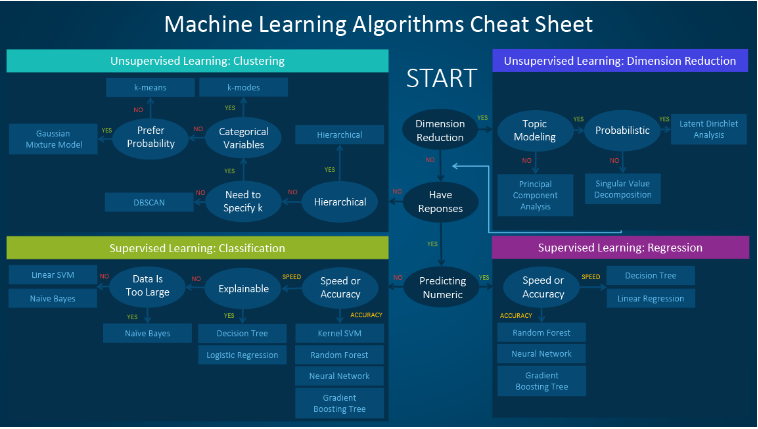

Image Reference: http://www.kdnuggets.com/2017/06/which-machine-learning-algorithm.html

**Logistic Regression:**

Logistic regression is a powerful statistical way of modeling a binomial outcome with one or more explanatory variables. It measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic function, which is the cumulative logistic distribution. It is the go-to method for binary classification problems (problems with two class values). A key difference from linear regression is that the output value being modeled is a binary values (0 or 1) rather than a numeric value.

Logistic regression is named for the function used at the core of the method, the logistic function. The logistic function, also called the sigmoid function was developed by statisticians to describe properties of population growth in ecology, rising quickly and maxing out at the carrying capacity of the environment. It’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits. 

    Logistic (sigmoid) function for a value x:  1 / (1 + e^-x)


* Real life applications: Logistic regression is used in various fields, including machine learning, most medical fields, and social sciences. For example, the Trauma and Injury Severity Score (TRISS), which is widely used to predict mortality in injured patients, was originally developed by Boyd et al. using logistic regression. Many other medical scales used to assess severity of a patient have been developed using logistic regression. Logistic regression may be used to predict whether a patient has a given disease (e.g. diabetes; coronary heart disease), based on observed characteristics of the patient (age, sex, body mass index, results of various blood tests, etc.). Another example might be to predict whether an American voter will vote Democratic or Republican, based on age, income, sex, race, state of residence, votes in previous elections, etc.[10] The technique can also be used in engineering, especially for predicting the probability of failure of a given process, system or product. It is also used in marketing applications such as prediction of a customer's propensity to purchase a product or halt a subscription, etc.[13] In economics it can be used to predict the likelihood of a person's choosing to be in the labor force, and a business application would be to predict the likelihood of a homeowner defaulting on a mortgage. Conditional random fields, an extension of logistic regression to sequential data, are used in natural language processing.

* Applicability: The outcome Charity ML dataset is known (supervised learning) and is binomial or binary (income<=50K or income>50K). Based on the cheat sheet image logistic regression is a good candidate classifier; and may provide a slight edge on speed vs. accuracy.


Logistic Regression references:

https://machinelearningmastery.com/logistic-regression-for-machine-learning/

https://en.wikipedia.org/wiki/Logistic_regression)


**Gaussian Naive Bayes:** 

Naive Bayes is a good proof that the simplest solutions are usually the most powerful ones. It has proven to not only be simple but also fast, accurate and reliable. It has been successfully used for many purposes, but it works particularly well with natural language processing (NLP) problems. This model is popular for text classification and spam filtering based on the likelihood of certain words appearing on an spam email as compared to a non-spam email.

Naive Bayes is a family of probabilistic algorithms that take advantage of probability theory and Bayes’ Theorem to predict the category of a sample (like a piece of news or a customer review). They are probabilistic, which means that they calculate the probability of each category for a given sample, and then output the category with the highest one. The way they get these probabilities is by using Bayes’ Theorem, which describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature.

The strength of the model is its simplicity arising from the assumption that all features needed correctly to classify the data are "independent" from each other. This lets the algorithm be trained quickly and using less data. When the underlying independence assumption is broken (features have relationships between them), this algorithm still generally performs quite well. A weakness of Naive Bayes is that if the classifier is used on a previously unseen feature-label combination (on which it was not trained) it will incorrectly classify the label. This particular model is a potential classifier for the CharityML dataset given the data set is large and has only a few features.


Naive Bayes References:

https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering).



**Adaboost** Adaptive Boosting or AdaBoost is a combination of multiple learning algorithms that can be utilized for regression or classification. It is a Boosting type Ensemble learning method. It overcomes overfitting when compared with any other machine learning algorithms and is often sensitive to outliers and noisy data. 

* Two main real life applications of AdaBoost are Remote Sensing and Person Recognition.
As satellite/sensor technology has improved, the amount of remote sensing data collected has expanded both in sheer volume (e.g., terabytes) and detail (e.g., hundreds of spectral bands). As a consequence, this domain poses distinct challenges to classification algorithms. Person recognition is the problem of verifying the identity of a person using characteristics of that person, typically for security applications. Examples include iris recognition, fingerprint recognition, face recognition, and behavior recognition (such as speech and handwriting)—recognizing characteristics of a person, as opposed to depending upon specific knowledge that the person may have (such as usernames and passwords for computer account access). Person recognition has historically been one of the most frequent applications of ensemble learning methods.


* In order to create one composite powerful learner, AdaBoost uses multiple iterations. So, it is termed as adaptive. By adding the weak learners iteratively, AdaBoost creates a strong learner. A new weak learner is appended to the entity and a weighing vector is adjusted in order to pay attention on examples that were classified incorrectly in the prior rounds. A classifier that has much higher accuracy than the classifiers of weak learners is the result. it is a fast algorithm, is classifier agnostic to the classifier and less prone to overfitting.

* Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. This technique is followed for a classification problem while a similar technique is used for regression.

* AdaBoost helps in boosting the weak threshold classifier to strong classifier. The image below depicts the implementation of AdaBoost in one single file with understandable code. The function contains a weak classifier and the boosting component. The weak classifier attempts to locate the ideal threshold in one of data dimensions to segregate the data into 2 classes. The classifier is called by the boosting part iteratively and after each classification step, it changes the weights of misclassified examples. Because of this, a cascade of weak classifiers is created and it behaves like a strong classifier. 

* Mathematically, classifier ensembles provide an extra degree of freedom in the classical bias/variance tradeoff, allowing solutions that would be difficult (if not impossible) to reach with only a single classifier. 

* Applicability: The Adaboost classifier is a good candidate for the CharityML classification problem as the dataset does not have too many features and, while the dataset is large, the data has been pre-cleaned. Therefore, Adaboost will be able to perform many quick iterations during training and has the potential to increase the overall accuracy on the yet unused testing data.

AdaBoost References:

http://www.kdnuggets.com/2017/06/machine-learning-algorithms-used-self-driving-cars.html

https://en.wikipedia.org/wiki/Boosting_(machine_learning)

https://pdfs.semanticscholar.org/7db2/1481c37237dd9e2a2547c880917dd14740b0.pdf

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html



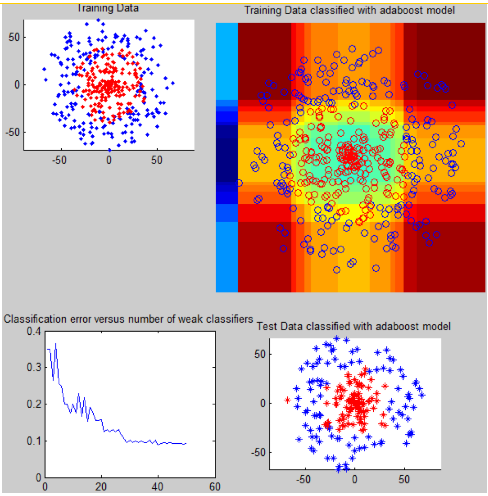

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
 
from time import time

beta = 0.5 # parameter used to calculate F-scores in both the training and the testing subsets

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    xs= X_train[:sample_size]
    ys = y_train[:sample_size]
    learner.fit(xs, ys)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])

    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train, beta=beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

## Model Set A: the three classifiers (Logistic Regression, GaussianNB, and AdaBoost)

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


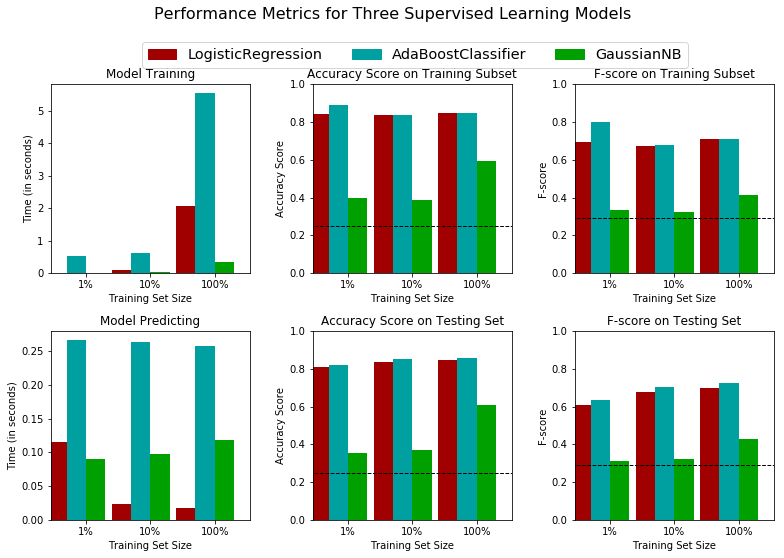

In [10]:

# TODO: Import the three supervised learning models from sklearn
# Model set A (Logistic Regression, GaussianNB, and AdaBoost)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=1111)
clf_B = GaussianNB()
clf_C = AdaBoostClassifier(random_state=3333)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = X_train.shape[0]
samples_1 = int(samples_100 * 0.01)
samples_10 = int(samples_100 * 0.1)


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

# Model Set B: Study three additional classifiers (due to curiosity) 

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
LinearSVC trained on 361 samples.
LinearSVC trained on 3617 samples.
LinearSVC trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.


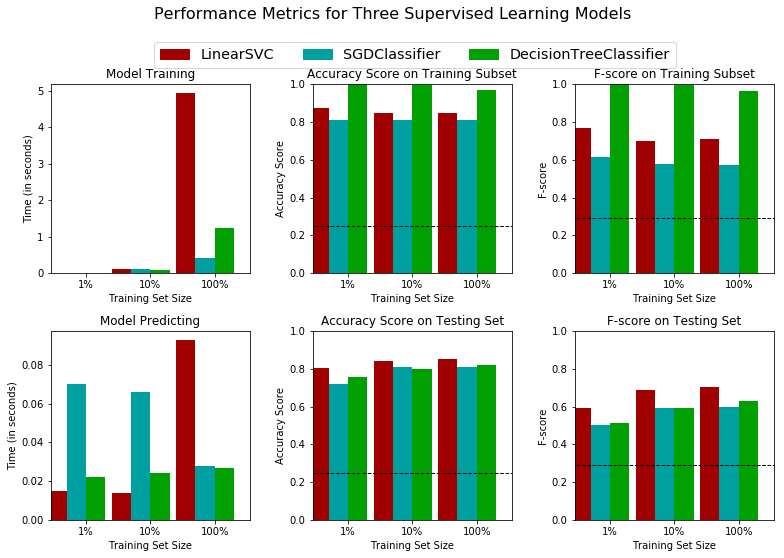

In [11]:
# Model set B (DecisionTreeClassifier, LinearSVC, and Stochastic Gradient Descent Classifier (SGDC))

# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

# TODO: Initialize the three models
clf_D = DecisionTreeClassifier(random_state=4100)
clf_E = LinearSVC(random_state=4200)
clf_F = SGDClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
#n_train = len(y_train)
samples_100 = X_train.shape[0]
samples_1 = int(samples_100 * 0.01)
samples_10 = int(samples_100 * 0.1)
#samples_100 = n_train

# Collect results on the learners
results = {}
for clf in [clf_D, clf_E, clf_F]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

## (Optional) Results and Discussion for Model Set B (DecisionTreeClassifier, LinearSVC, and Stochastic Gradient Descent Classifier (SGDC))


* The Decision Tree Classifier yielded very high accuracy and F-score for the training set, nearly 100%. However, the accuracy and score dropped off significantly tor the testing set. This is not good, annd indicates overfitting. For this reason, the Decision Tree Classifier, with default parameters, is not a good choice for the CharityML case without rigorous parameter tuning.
 
* Both the Support Vector classifier LineraSVC, and the SGD classifiers yielded similar training accuracy but lower than the three classifiers in Model A discussed above. The F-Scores were also generally lower than the three Model Set A classifiers.

* The LinearSVC model required the longest time to classify the CharityML dataset.


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

I think the **AdaBoost model** is likely to be the most appropriate for the task of identifying individuals that make more than $50,000. The conclusion is based on the discussion below based on the plots above. Although thetraining time is higher for AdaBoost, it is expected that with parameter tuning, the Adaboost model accuracy and timing performance will increase. 

* Training Accuracy: Adaboost and Logistic Regression are quite close and above 0.8, Adaboost slightly higher. GaussianNB is lower around 0.6

* Testing Accuracy: Adaboost and Logistic Regression are quite close and above 0.8, Adaboost slightly higher. GaussianNB is lower around 0.6

* Accuracy Difference (Training - Testing): Small for all three classifiers indicating overfitting is not affecting the testing accuracy.

* F-Score: Adaboost and Logistic Regression are quite close and above 0.7, Adaboost slightly higher. GaussianNB is lower around 0.4

* Training time: Higher for Adaboost than the Logistic regression or the GaussianNB model. 

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 


* Background: This machine learning project uses several supervised classifier algorithms (Logistic Regression, AdaBoost Ensemble, Gaussian Naive Bayes, LinearSVC, Decision Tree, and Stochastic Gradient Descent) to accurately model individuals' income using data collected from the 1994 U.S. Census. The best candidate algorithm is then chosen from preliminary results and this algorithm is further optimized to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than 50K. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we demonstrate in this project) infer this value from other publically available data features.
The dataset for this project originates from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Census+Income).


* Model: AdaBoost is the final model selected. Adaptive Boosting or AdaBoost is a combination of multiple learning algorithms that can be utilized for regression or classification. It is a Boosting type Ensemble learning method. It overcomes overfitting when compared with any other machine learning algorithms and is often sensitive to outliers and noisy data. In order to create one composite powerful learner, AdaBoost uses multiple iterations. So, it is termed as adaptive. By adding the weak learners iteratively, AdaBoost creates a strong learner. A new weak learner is appended to the entity and a weighing vector is adjusted in order to pay attention on examples that were classified incorrectly in the prior rounds. A classifier that has much higher accuracy than the classifiers of weak learners is the result. it is a fast algorithm, is classifier agnostic to the classifier and less prone to overfitting. Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. This technique is followed for a classification problem while a similar technique is used for regression.


* Method and Results: The CharityML dataset is split into training dataset and a test dataset. The AdaBoost model is trained to predict and identify the individuals in the dataset who earn more than 50K. the trained Adaboost Model is then applied to the test dataset to predict whether the income is above or not above 50K. The accuracy of prediction and a representative score (F-score) is calculated by comparing predicted income with actual. This prediction is further refined/optimized by tuning a few model parameters to produce better accuracy and F-score.   

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

#### Tuning the Logistic Regression Classifier model

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = LogisticRegression()

# TODO: Create the parameters list you wish to tune
# Parameters chosen are 'solver', 'C', 'random_state', and 'max_iter'
# The parameters descriptions areavailable here: 
    #http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

parameters = {'solver': ['lbfgs', 'sag'],
              'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'random_state': [7999, 8999], 'max_iter': [300, 400]}

# We should choose that value of parameter C which offers the smallest difference between the training and testing accuracy.
# Recall we want to generalise our model to unseen data.


# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))


Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8493
Final F-score on the testing data: 0.7006


#### Tuning the AdaBoost Classifier model

In [13]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=20170914)

# TODO: Create the parameters list you wish to tune
parameters = {'learning_rate':[0.01, 0.05, 1.0], 'n_estimators':[300, 500, 1000]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))


Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

 * Logistic Regression*

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              |0.8483             |0.8493           |
| F-score        | 0.2917              |0.6993             |0.7006           |


* AdaBoost (yields higher accuracy and F-score than Logistic Regression)*

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              |0.8576             |**0.8676**       |
| F-score        | 0.2917              |0.7246             |**0.7448**       |


**Answer: **

* From the three classifier models chosen in Model Set A (LogisticRegression, GaussianNB, and AdaBoost), **parameter tuning with GridSearchCV was performed for two classifiers (LogisticRegression and AdaBoost)** to further study relative parameter tuning sensitivity and impact on accuracy and the F-Score.


* Both Logistic Regression and AdaBoost classifiers yielded much higher accuracy and F-Scores than the Benchmark Predictor.


* The optimized models indicate increase in accuracy and score for both Logistic Regression and AdaBoost. **Adaboost shows relaively larger gain in accuracy and score from parameter tuning.**


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

I think the top five features relevant to accurately classifying the people into the two binary categories (<=50K , and >50K) features are as follows, with the rationale for the choice indicated in parenthesis.

1- Education-num (Higher education generally leads to better paying jobs and higher incomes (>50K) and savings to be able to afford giving to Charity). 

2- Hours per week (Higher hours per week means more income for similar pay rates. Also salaried employees tend to have higher pay rates than hourly employees, and may have income >50K).

3- Age (Middle-age people usually have higher incomes and tend to give to Charities more).

4/5- Capital Gain/Loss: Those who have worked for many years e.g. baby-boomers, have accumulated savings (capital) that they usually invest or spend. If the investment is risky they may have capital loss. So capital gain/loss are relevant features.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

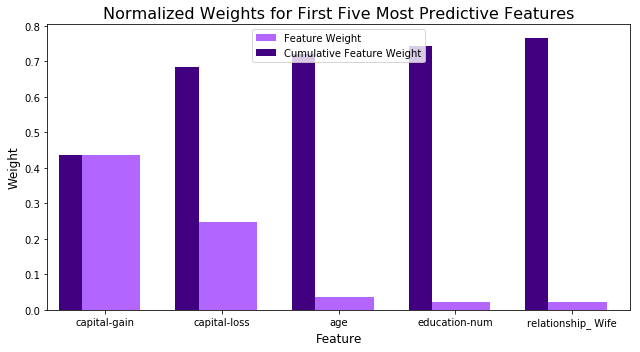


Model accuracy: 0.86357103372 , fscore:  0.738458211699

 top ten important features


,importances,features
2,0.437,capital-gain
3,0.247,capital-loss
0,0.037,age
1,0.023,education-num
54,0.022,relationship_ Wife
4,0.02,hours-per-week
61,0.014,sex_ Male
38,0.011,occupation_ Exec-managerial
44,0.011,occupation_ Prof-specialty
30,0.009,marital-status_ Married-civ-spouse


In [14]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier(learning_rate=0.2, n_estimators=1000, random_state=555).fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

# Display accuracy and score
m_pred = model.predict(X_test)
m_accuracy = accuracy_score(y_test, m_pred)
fbscore = fbeta_score(y_test, m_pred, beta=0.5)
print "\nModel accuracy:", m_accuracy, ", fscore: ", fbscore

# Determine importance features

imp_features = pd.DataFrame(data = np.array([importances.astype(float), features.columns]).T,
                       columns = ['importances', 'features'])
imp_features = imp_features.sort_values('importances', ascending=False)

print "\n top ten important features"
display(imp_features[:10])

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**
My intuitive answer for Question 6 matches 4 items out of the top 5 obtained in the "Implementation - Extracting Feature Importance" exercise above. the matches are Education-num, Age, Capital gain and Capital loss. The visualizition confirms general reasing soundness. However, I was a bit surprised that capital gain and capital loss were the top two identified in the feature importance exercise. This result definitely underscores the necessity of using the feature importance methodology to use a reduced feature set rather than adhoc choices.  

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8676
F-score on testing data: 0.7448

Final Model trained on reduced data
------
Accuracy on testing data: 0.8373
F-score on testing data: 0.6869


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

* From metrics tabulated below, the reduced features model (with only top five features) does quite well with only modest decrease in accuracy and F-score.


* If training time was a factor, I would definitely consider using the reduced data as training set.



|     Metric     | All(13)Features Model  | Reduced (5) Features Model | Comments      |
| :------------: | :-----------------: | :----------------------------:|:-------------:| 
| Accuracy Score | 0.8676              |0.8373                         | 0.033 decrease|
| F-score        | 0.7448              |0.6869                         | 0.058 decrease|



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.